In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
import torchvision.utils as vutils
import models
from visualize import *
from data import *
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")
data_path = './cosmo'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load dataset and model

In [3]:
# params
img_size = 256
class_num = 1

# cosmo dataset
transformer = transforms.Compose([ToTensor()])
mnu_dataset = MassMapsDataset(opj(data_path, 'cosmological_parameters.txt'),  
                              opj(data_path, 'z1_256'),
                              transform=transformer)

# dataloader
data_loader = torch.utils.data.DataLoader(mnu_dataset, batch_size=32, shuffle=True, num_workers=4)

# load model
model = models.load_model(model_name='resnet18', device=device, data_path=data_path).to(device)
model = model.eval()
# freeze layers
for param in model.parameters():
    param.requires_grad = False

100%|██████████| 100/100 [00:06<00:00, 15.04it/s]


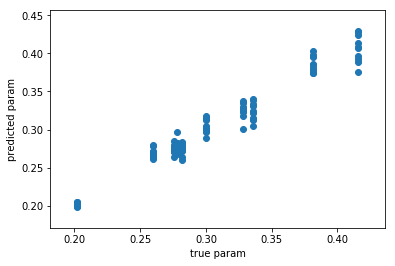

In [4]:
with torch.no_grad():
    result = {'y': [], 'pred': []}
    for i in tqdm(range(100)):
        sample = mnu_dataset[i]
        x = sample['image']
        result['y'].append(sample['params'][1].item())
        result['pred'].append(model(x.unsqueeze(0).to(device)).flatten()[1].item())
# print(result)
plt.scatter(result['y'], result['pred'])
plt.xlabel('true param')
plt.ylabel('predicted param')
plt.show()

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.convt1 = nn.ConvTranspose2d(64, 1, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False)
        
    def forward(self, x):
        return self.convt1(x)
    

class Reconstruction(nn.Module):
    def __init__(self, model, generator):
        super(Reconstruction, self).__init__()
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu1 = model.relu
        self.maxpool1 = model.maxpool
        self.maxpool1.return_indices = True
        self.unpool1 = nn.MaxUnpool2d(kernel_size=3, stride=2, padding=1)
        self.convt1 = generator.convt1
        
        # freeze conv1 and bn1
        self.conv1
        
    def feature_map(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x, ind = self.maxpool1(x)
        x = self.unpool1(x, ind, output_size=torch.Size([30, 64, 128, 128]))
        return x
        
    def forward(self, x):
        x = self.feature_map(x)
        return self.convt1(x)
    
    
def gradient_pen(gen_frames, alpha=2):

    def gradient(x):
        # idea from tf.image.image_gradients(image)
        # https://github.com/tensorflow/tensorflow/blob/r2.1/tensorflow/python/ops/image_ops_impl.py#L3441-L3512
        # x: (b,c,h,w), float32 or float64
        # dx, dy: (b,c,h,w)

        h_x = x.size()[-2]
        w_x = x.size()[-1]
        # gradient step=1
        left = x
        right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
        top = x
        bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]

        # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
        dx, dy = right - left, bottom - top 
        # dx will always have zeros in the last column, right-left
        # dy will always have zeros in the last row,    bottom-top
        dx[:, :, :, -1] = 0
        dy[:, :, -1, :] = 0

        return dx, dy
    
    # gradient
    gen_dx, gen_dy = gradient(gen_frames)
    
    # condense into one tensor and avg
    return torch.mean(gen_dx ** alpha + gen_dy ** alpha)       

In [5]:
# model
netG = Generator().to(device)
# netG.load_state_dict(torch.load('./models/conv_filters_pen'))

# prepend model and netG
netR = Reconstruction(model, netG).to(device)

# criterion
criterion = nn.MSELoss()

# Setup Adam optimizers for G
optimizerG = optim.Adam(netG.parameters(), lr=0.0005)

# mask
padding = 3
dim = padding*2+1
mask = torch.ones(64, 64, dim, dim).to(device)
for i in range(64):
    mask[i,i,padding,padding] = 0
    
zeros = torch.zeros(64, 64, dim, dim).to(device)

# conv operator for penalty
c = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=padding, bias=False).to(device)

In [6]:
# Training Loop
# Lists to keep track of progress
G_losses = []
num_epochs = 5

lamb = 1.0
lamb_smth = 0.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(data_loader, 0):
        inputs, params = data['image'], data['params']
        if device == 'cuda':
            inputs = inputs.to(device)
            params = params.to(device)
        inputs_ = netR(inputs)
        # loss
        loss = criterion(inputs, inputs_)
        # pen
        c.weight = netG.convt1.weight
        inner_prod = c(netG.convt1.weight)
        loss += lamb*criterion(inner_prod * mask, zeros)
        # smth
        loss += lamb_smth*gradient_pen(netG.convt1.weight)
        # zero grad
        netG.zero_grad()
        # backward
        loss.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(data_loader.dataset),
                       100. * i / len(data_loader), loss.data.item()), end='')
            torch.save(netG.state_dict(), './models/conv_filters_pen_' + str(int(lamb)) + '_' + str(int(lamb_smth)) \
                                                                              + '_' + str(int(padding)))

        # Save Losses for plotting later
        G_losses.append(loss.item())


Starting Training Loop...
Train Epoch: 4 [99200/100000 (99%)]	Loss: 0.000012

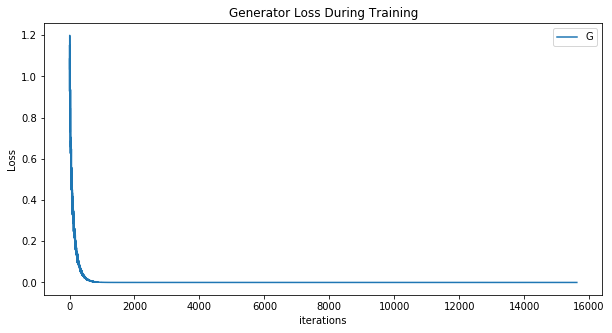

In [7]:
# loss versus training iterations
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses, label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

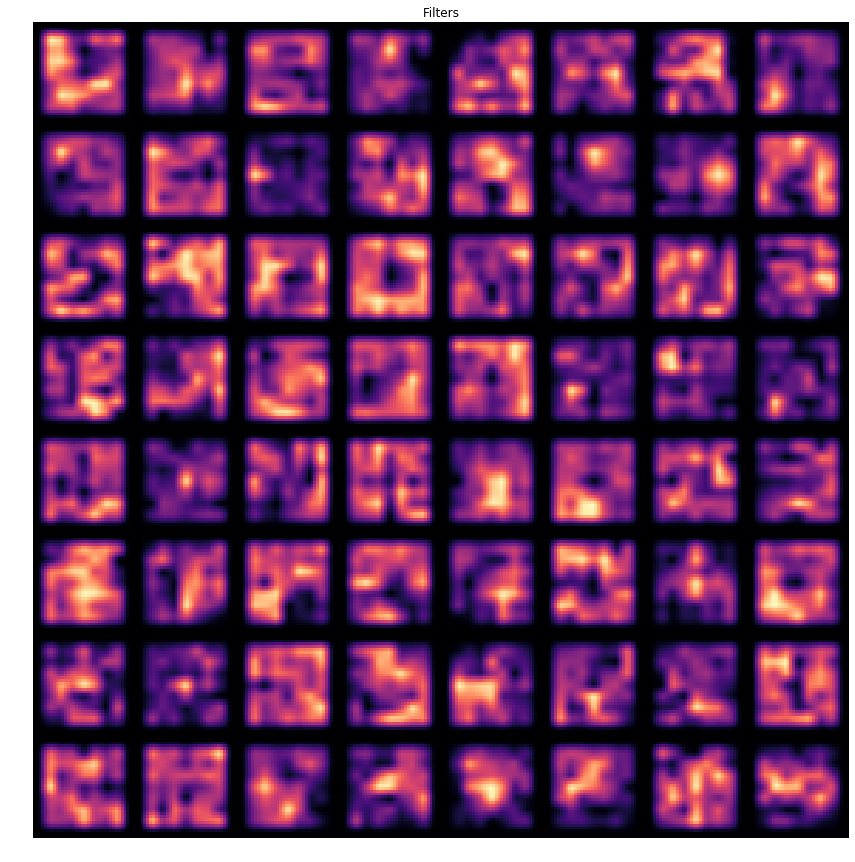

In [8]:
# viz filters
viz_filters(netG)

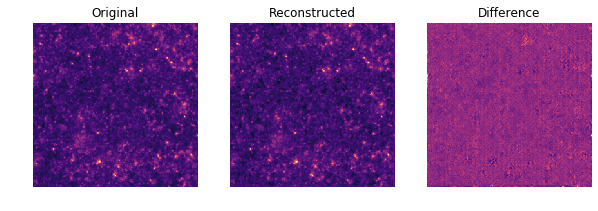

0.0010131192239887753


In [9]:
im = mnu_dataset[25000]['image'].to(device).unsqueeze(0)
viz_im_r(im, netR(im))
print(torch.norm(im - netR(im)).item()**2/28**2)